In [139]:
import pandas as pd
import numpy as np

データの読み込み

In [140]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [141]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


学習データを特徴量と目的変数に分ける

In [142]:
train_x = train.drop(['Survived'],axis=1)
train_y = train['Survived']

#テストデータは特徴量のみなのでそのまま
test_x = test.copy()

データの揺れ(型)を確認する

In [143]:
train_x.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

データの欠損値の確認をする

In [144]:
train_x.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [145]:
test_x.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

####  変数の削除をする

In [146]:
#変数PassengeerIdを削除する
train_x = train_x.drop(['PassengerId'],axis=1)
test_x = test_x.drop(['PassengerId'],axis=1)

## データの確認

年齢の分布を確認

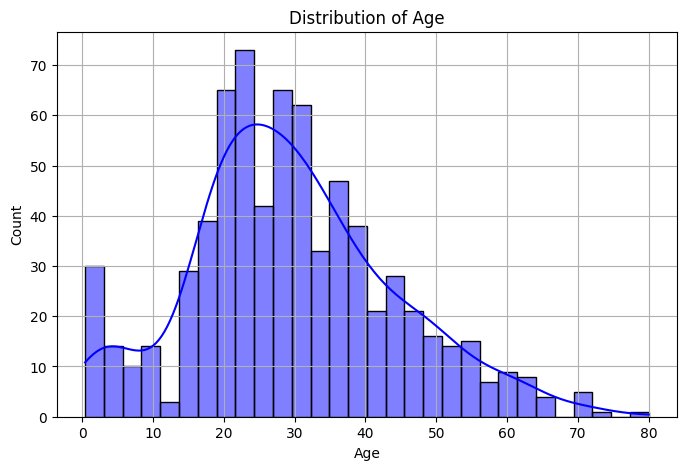

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(train_x['Age'], bins=30, kde=True, color='blue')  # KDE=Trueで確率密度関数も描画
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.grid(True)
plt.show()

NaNが2つ以上ある行を確認

In [148]:
nan_rows = train_x[train_x.isna().sum(axis=1) >= 2]
print(nan_rows)
#3個あるものはなかった

     Pclass                                      Name     Sex  Age  SibSp  \
5         3                          Moran, Mr. James    male  NaN      0   
17        2              Williams, Mr. Charles Eugene    male  NaN      0   
19        3                   Masselmani, Mrs. Fatima  female  NaN      0   
26        3                   Emir, Mr. Farred Chehab    male  NaN      0   
28        3             O'Dwyer, Miss. Ellen "Nellie"  female  NaN      0   
..      ...                                       ...     ...  ...    ...   
859       3                          Razi, Mr. Raihed    male  NaN      0   
863       3         Sage, Miss. Dorothy Edith "Dolly"  female  NaN      8   
868       3               van Melkebeke, Mr. Philemon    male  NaN      0   
878       3                        Laleff, Mr. Kristo    male  NaN      0   
888       3  Johnston, Miss. Catherine Helen "Carrie"  female  NaN      1   

     Parch      Ticket     Fare Cabin Embarked  
5        0      330877   8

ただ乗りしている人がいる！？

In [149]:
fare_zero_rows = train_x[train_x['Fare'] == 0]
print(fare_zero_rows)

     Pclass                              Name   Sex   Age  SibSp  Parch  \
179       3               Leonard, Mr. Lionel  male  36.0      0      0   
263       1             Harrison, Mr. William  male  40.0      0      0   
271       3      Tornquist, Mr. William Henry  male  25.0      0      0   
277       2       Parkes, Mr. Francis "Frank"  male   NaN      0      0   
302       3   Johnson, Mr. William Cahoone Jr  male  19.0      0      0   
413       2    Cunningham, Mr. Alfred Fleming  male   NaN      0      0   
466       2             Campbell, Mr. William  male   NaN      0      0   
481       2  Frost, Mr. Anthony Wood "Archie"  male   NaN      0      0   
597       3               Johnson, Mr. Alfred  male  49.0      0      0   
633       1     Parr, Mr. William Henry Marsh  male   NaN      0      0   
674       2        Watson, Mr. Ennis Hastings  male   NaN      0      0   
732       2              Knight, Mr. Robert J  male   NaN      0      0   
806       1            An

## 特徴量の作成

### 行のNaNの数の特徴量を作成する

In [150]:
#train_x["num_missing"] = train_x.isna().sum(axis=1)
#test_x["num_missing"] = test_x.isna().sum(axis=1)

### Fareが０の特徴量の列の作成

In [151]:
#使えなかった
train_x["fare_zero"] = (train_x['Fare'] == 0).astype(int)
test_x["fare_zero"] = (test_x['Fare'] == 0).astype(int)

In [152]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, brier_score_loss
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

### Cabinから新たな特徴量を作成する

In [153]:
train_x['Cabin_Deck'] = train_x['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else np.nan)
test_x['Cabin_Deck'] = test_x['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else np.nan)

print(train_x['Cabin_Deck'])


0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: Cabin_Deck, Length: 891, dtype: object


### Name列からタイトルを抽出

In [154]:
# Name列からタイトルを抽出
train_x['Title'] = train_x['Name'].str.extract(r',\s*([^\.]+)\.')
test_x['Title'] = test_x['Name'].str.extract(r',\s*([^\.]+)\.')

# 稀なタイトルを結合
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 
               'Jonkheer', 'Dona', 'Mlle', 'Mme', 'Ms', 'the Countess']
train_x['Title'] = train_x['Title'].replace(rare_titles,'Rare')
test_x['Title'] = test_x['Title'].replace(rare_titles,'Rare')

print(train_x['Title'].value_counts())
print(test_x['Title'].value_counts())

Title
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64
Title
Mr        240
Miss       78
Mrs        72
Master     21
Rare        7
Name: count, dtype: int64


### 家族人数の特徴量の作成をする

In [155]:
#家族人数の合計
train_x['FamilySize'] = train_x['SibSp'] + train_x['Parch'] + 1
test_x['FamilySize'] = test_x['SibSp'] + test_x['Parch'] + 1

### 料金/家族人数の特徴量を作成する

In [156]:
train_x['FarePerFamilyMember'] = train_x['Fare'] / train_x['FamilySize']
test_x['FarePerFamilyMember'] = test_x['Fare'] / train_x['FamilySize']

train_x['FarePerFamilyMember']

0       3.62500
1      35.64165
2       7.92500
3      26.55000
4       8.05000
         ...   
886    13.00000
887    30.00000
888     5.86250
889    30.00000
890     7.75000
Name: FarePerFamilyMember, Length: 891, dtype: float64

### LastNameの特徴量を作成する

In [157]:
#姓(LastName)を抽出して新しい列に追加
train_x['LastName'] = train['Name'].str.split(',').str[0]
test_x['LastName'] = test['Name'].str.split(',').str[0]

In [158]:
train_x['LastName'].value_counts()

LastName
Andersson    9
Sage         7
Panula       6
Skoog        6
Carter       6
            ..
Hanna        1
Lewy         1
Mineff       1
Haas         1
Dooley       1
Name: count, Length: 667, dtype: int64

### LastNameからSameNameの列を作成する

In [159]:
#LastNameの登場回数を記録
train_x['Same_Name'] = train_x['LastName'].map(train_x['LastName'].value_counts())
test_x['Same_Name'] = test_x['LastName'].map(test_x['LastName'].value_counts())

### Ticketから特徴量を作る

In [160]:
def classify_ticket(ticket):
    #  1. Numeric（すべて数値）
    if ticket.isdigit():
        return "Numeric"
    
    #  2. SpecialChar（"/" や "." を含む場合）
    elif "/" in ticket or "." in ticket:
        return "SpecialChar"
    
    #  3. Alphanumeric（英字と数字の両方を含む場合）
    elif any(char.isdigit() for char in ticket) and any(char.isalpha() for char in ticket):
        return "Alphanumeric"
    
    #  4. Unknown（どれにも当てはまらない場合）
    else:
        return "Unknown"

In [161]:
train_x["Ticket_Tpye"] = train_x["Ticket"].apply(classify_ticket)
test_x["Ticket_Tpye"] = test_x["Ticket"].apply(classify_ticket)
print(train_x['Ticket_Tpye'].value_counts())

Ticket_Tpye
Numeric         661
SpecialChar     150
Alphanumeric     76
Unknown           4
Name: count, dtype: int64


In [162]:
#正しく分類できているか確認
train_x[train_x["Ticket_Tpye"] == "SpecialChar"]["Ticket"]

0             A/5 21171
2      STON/O2. 3101282
12            A/5. 2151
33           C.A. 24579
37           A./5. 2152
             ...       
866       SC/PARIS 2149
874           P/PP 3381
883    C.A./SOTON 34068
884     SOTON/OQ 392076
888          W./C. 6607
Name: Ticket, Length: 150, dtype: object

### 子どもだけの特徴量を作成したい

In [163]:
#妻から夫を算出
filtered_rows = train_x[(train_x["Title"] == "Mrs") & (train_x["SibSp"] == 1)]
print(filtered_rows)

     Pclass                                               Name     Sex   Age  \
1         1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
9         2                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0   
18        3  Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0   
25        3  Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  female  38.0   
..      ...                                                ...     ...   ...   
849       1       Goldenberg, Mrs. Samuel L (Edwiga Grabowska)  female   NaN   
854       2      Carter, Mrs. Ernest Courtenay (Lilian Hughes)  female  44.0   
856       1         Wick, Mrs. George Dennick (Mary Hitchcock)  female  45.0   
871       1   Beckwith, Mrs. Richard Leonard (Sallie Monypeny)  female  47.0   
874       2              Abelson, Mrs. Samuel (Hannah Wizosky)  female  28.0   

     SibSp  Parch     Ticket      Fare 

### 子か親の欄を2人いる時は親だと仮定して特徴量の作成

In [164]:
#train_x['Parch_child'] = (train_x['Parch']==2) & ((train_x['Title'] == 'Miss') | (train_x['Parch'] == 'Master'))
#train_x

### Ageデータの結合

In [165]:
train_age_data = pd.read_csv('age_data/train_age_data1.csv')
test_age_data = pd.read_csv('age_data/test_age_data1.csv')

train_x = pd.concat([train_x,train_age_data['Predict_Age']],axis=1)
test_x = pd.concat([test_x,test_age_data['Predict_Age']],axis=1)

### Ageを二値に分類

In [166]:
train_x['Age_missing'] = train_x['Age'].isnull().astype(int)
test_x['Age_missing'] = test_x['Age'].isnull().astype(int)

### LastNameの長さから特徴量を作成する

In [167]:
# 名前の長さを特徴量として追加
train_x['LastName_length'] = train_x['LastName'].apply(len)
test_x['LastName_length'] = test_x['LastName'].apply(len)

# 確認
print(train_x[['LastName', 'LastName_length']].head())

    LastName  LastName_length
0     Braund                6
1    Cumings                7
2  Heikkinen                9
3   Futrelle                8
4      Allen                5


# Cabinの欠損値を埋める

In [168]:
# 'Ticket_Tpye' と 'Cabin_Deck' のユニークな値を確認
print("Ticket_Tpyeのユニークな値:")
print(train_x['Ticket_Tpye'].unique())

print("\nCabin_Deckのユニークな値:")
print(train_x['Cabin_Deck'].unique())


Ticket_Tpyeのユニークな値:
['SpecialChar' 'Alphanumeric' 'Numeric' 'Unknown']

Cabin_Deckのユニークな値:
[nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


In [169]:
# クロス集計を使って関係性を確認
cross_tab = pd.crosstab(train_x['Ticket_Tpye'], train_x['Cabin_Deck'])
print(cross_tab)


Cabin_Deck     A   B   C   D   E   F  G  T
Ticket_Tpye                               
Alphanumeric   3  13  15   5   6   0  2  0
Numeric       12  31  44  26  23  11  2  1
SpecialChar    0   3   0   2   3   2  0  0


In [170]:
# クロス集計を使って関係性を確認
cross_tab = pd.crosstab(train_x['Pclass'], train_x['Cabin_Deck'])
print(cross_tab)


Cabin_Deck   A   B   C   D   E  F  G  T
Pclass                                 
1           15  47  59  29  25  0  0  1
2            0   0   0   4   4  8  0  0
3            0   0   0   0   3  5  4  0


In [171]:
# Pclass と Cabin_Deck のクロス集計を行い、その後に Ticket_Tpye を確認
cross_tab_2 = pd.crosstab([train_x['Pclass'], train_x['Cabin_Deck']], train_x['Ticket_Tpye'])
print(cross_tab_2)


Ticket_Tpye        Alphanumeric  Numeric  SpecialChar
Pclass Cabin_Deck                                    
1      A                      3       12            0
       B                     13       31            3
       C                     15       44            0
       D                      5       24            0
       E                      6       18            1
       T                      0        1            0
2      D                      0        2            2
       E                      0        3            1
       F                      0        6            2
3      E                      0        2            1
       F                      0        5            0
       G                      2        2            0


In [172]:
# 数値型のカラムだけを選択して相関を計算
numeric_columns = train_x.select_dtypes(include=['number']).columns
correlation_matrix = train_x[numeric_columns].corr()

# 相関行列を表示
print(correlation_matrix)


                       Pclass       Age     SibSp     Parch      Fare  \
Pclass               1.000000 -0.369226  0.083081  0.018443 -0.549500   
Age                 -0.369226  1.000000 -0.308247 -0.189119  0.096067   
SibSp                0.083081 -0.308247  1.000000  0.414838  0.159651   
Parch                0.018443 -0.189119  0.414838  1.000000  0.216225   
Fare                -0.549500  0.096067  0.159651  0.216225  1.000000   
fare_zero           -0.058774  0.037315 -0.062097 -0.061983 -0.084850   
FamilySize           0.065997 -0.301914  0.890712  0.783111  0.217138   
FarePerFamilyMember -0.485079  0.150763 -0.094682 -0.068978  0.840995   
Same_Name            0.113262 -0.227600  0.667568  0.600538  0.105880   
Predict_Age         -0.395087  1.000000 -0.314138 -0.214481  0.097061   
Age_missing          0.172933       NaN  0.018958 -0.124104 -0.100707   
LastName_length      0.005029 -0.011401 -0.046958 -0.076696 -0.044505   

                     fare_zero  FamilySize  FarePe

### 最終データ確認

In [173]:
train_x.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Cabin_Deck,Title,FamilySize,FarePerFamilyMember,LastName,Same_Name,Ticket_Tpye,Predict_Age,Age_missing,LastName_length
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,...,NaN,Mr,2,3.62500,Braund,2,SpecialChar,22.0,0,6
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,...,C,Mrs,2,35.64165,Cumings,1,Alphanumeric,38.0,0,7
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,...,NaN,Miss,1,7.92500,Heikkinen,1,SpecialChar,26.0,0,9
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,...,C,Mrs,2,26.55000,Futrelle,2,Numeric,35.0,0,8
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,...,NaN,Mr,1,8.05000,Allen,2,Numeric,35.0,0,5


In [174]:
test_x.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Cabin_Deck,Title,FamilySize,FarePerFamilyMember,LastName,Same_Name,Ticket_Tpye,Predict_Age,Age_missing,LastName_length
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,...,NaN,Mr,1,3.91460,Kelly,1,Numeric,34.5,0,5
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,...,NaN,Mrs,2,3.50000,Wilkes,1,Numeric,47.0,0,6
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,...,NaN,Mr,1,9.68750,Myles,1,Numeric,62.0,0,5
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,...,NaN,Mr,1,4.33125,Wirz,1,Numeric,27.0,0,4
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,...,NaN,Mrs,3,12.28750,Hirvonen,1,Numeric,22.0,0,8


### 変更した特徴量の削除

In [175]:
#変数を削除する
train_x = train_x.drop(['Name','Ticket','LastName','fare_zero','Age_missing','Cabin'],axis=1)
test_x = test_x.drop(['Name','Ticket','LastName','fare_zero','Age_missing','Cabin'],axis=1)

### one-hot encodingを行う

In [176]:
"""
# One-hot encoding
for c in ['Title','Sex','Ticket_Tpye']:
    combined = pd.concat([train_x[c], test_x[c]], axis=0)
    combined_dummies = pd.get_dummies(combined, prefix=c)
    
    train_x = train_x.join(combined_dummies[:len(train_x)])
    test_x = test_x.join(combined_dummies[len(train_x):])

    train_x.drop(c, axis=1, inplace=True)
    test_x.drop(c, axis=1, inplace=True)
"""

"\n# One-hot encoding\nfor c in ['Title','Sex','Ticket_Tpye']:\n    combined = pd.concat([train_x[c], test_x[c]], axis=0)\n    combined_dummies = pd.get_dummies(combined, prefix=c)\n    \n    train_x = train_x.join(combined_dummies[:len(train_x)])\n    test_x = test_x.join(combined_dummies[len(train_x):])\n\n    train_x.drop(c, axis=1, inplace=True)\n    test_x.drop(c, axis=1, inplace=True)\n"

### label enocdingを行う

In [177]:
from sklearn.preprocessing import LabelEncoder

for c in ['Embarked','Title','Sex','Ticket_Tpye','Cabin_Deck']:
    #学習データをどう変換するかを決める
    le = LabelEncoder()
    le.fit(train_x[c].fillna('NA')) #欠損値の変換

    train_x[c] = le.transform(train_x[c].fillna('NA'))
    test_x[c] = le.transform(test_x[c].fillna('NA'))

In [178]:
train_x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Deck,Title,FamilySize,FarePerFamilyMember,Same_Name,Ticket_Tpye,Predict_Age,LastName_length
0,3,1,22.0,1,0,7.2500,3,7,2,2,3.62500,2,2,22.0,6
1,1,0,38.0,1,0,71.2833,0,2,3,2,35.64165,1,0,38.0,7
2,3,0,26.0,0,0,7.9250,3,7,1,1,7.92500,1,2,26.0,9
3,1,0,35.0,1,0,53.1000,3,2,3,2,26.55000,2,1,35.0,8
4,3,1,35.0,0,0,8.0500,3,7,2,1,8.05000,2,1,35.0,5


In [179]:
train_x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Deck,Title,FamilySize,FarePerFamilyMember,Same_Name,Ticket_Tpye,Predict_Age,LastName_length
0,3,1,22.0,1,0,7.2500,3,7,2,2,3.62500,2,2,22.000000,6
1,1,0,38.0,1,0,71.2833,0,2,3,2,35.64165,1,0,38.000000,7
2,3,0,26.0,0,0,7.9250,3,7,1,1,7.92500,1,2,26.000000,9
3,1,0,35.0,1,0,53.1000,3,2,3,2,26.55000,2,1,35.000000,8
4,3,1,35.0,0,0,8.0500,3,7,2,1,8.05000,2,1,35.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,3,7,4,1,13.00000,1,1,27.000000,8
887,1,0,19.0,0,0,30.0000,3,1,1,1,30.00000,3,1,19.000000,6
888,3,0,NaN,1,2,23.4500,3,7,1,4,5.86250,2,2,7.481854,8
889,1,1,26.0,0,0,30.0000,0,2,2,1,30.00000,1,1,26.000000,4


# Cabinを予測する

In [180]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

# 欠損がないデータを選定
train_not_missing = train_x[train_x['Cabin_Deck'].notnull()]

# 特徴量とターゲットを分ける
X = train_not_missing.drop(columns=['Cabin_Deck'])
y = train_not_missing['Cabin_Deck']

# 学習用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoostモデルの訓練
model = xgb.XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train)

# 検証データで予測
y_pred = model.predict(X_val)

# 精度の確認
print("Accuracy on validation set: ", accuracy_score(y_val, y_pred))

# 他の評価基準
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nF1 Score: ", f1_score(y_val, y_pred, average='weighted'))  # 加重平均を使用
print("Precision: ", precision_score(y_val, y_pred, average='weighted'))  # 加重平均を使用
print("Recall: ", recall_score(y_val, y_pred, average='weighted'))  # 加重平均を使用

# 欠損値があるデータに予測を行う
train_missing = train_x[train_x['Cabin_Deck'].isnull()]
X_missing = train_missing.drop(columns=['Cabin_Deck'])
predicted_decks = model.predict(X_missing)

# 欠損値を補完
train_x.loc[train_x['Cabin_Deck'].isnull(), 'Cabin_Deck'] = predicted_decks


Accuracy on validation set:  0.7597765363128491
Confusion Matrix:
 [[  0   2   1   0   1   0   0   1]
 [  0   5   2   0   0   0   0   2]
 [  0   0   1   1   3   0   0   2]
 [  0   2   3   4   1   0   0   4]
 [  1   0   2   1   2   0   0   2]
 [  0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   1]
 [  1   3   4   0   1   1   0 124]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.42      0.56      0.48         9
           2       0.08      0.14      0.10         7
           3       0.67      0.29      0.40        14
           4       0.25      0.25      0.25         8
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.91      0.93      0.92       134

    accuracy                           0.76       179
   macro avg       0.29      0.27      0.27       179
weighted avg       0.76      0.

/opt/homebrew/var/pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/var/pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/var/pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [181]:
from sklearn.preprocessing import LabelEncoder

# 再度LabelEncoderを定義
label_encoder = LabelEncoder()

# 'Cabin_Deck'のラベルをエンコード（train_xに基づいて）
label_encoder.fit(train_x['Cabin_Deck'].dropna())

# test_xの欠損値を予測
test_missing = test_x[test_x['Cabin_Deck'].isnull()]
X_test_missing = test_missing.drop(columns=['Cabin_Deck'])

# 学習したモデルを使ってtest_xの欠損値を予測
predicted_decks_test_encoded = model.predict(X_test_missing)

# エンコードした予測結果を元のラベルに戻す
predicted_decks_test = label_encoder.inverse_transform(predicted_decks_test_encoded)

# test_xの欠損値を補完
test_x.loc[test_x['Cabin_Deck'].isnull(), 'Cabin_Deck'] = predicted_decks_test


In [182]:
train_x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Deck,Title,FamilySize,FarePerFamilyMember,Same_Name,Ticket_Tpye,Predict_Age,LastName_length
0,3,1,22.0,1,0,7.2500,3,7,2,2,3.62500,2,2,22.000000,6
1,1,0,38.0,1,0,71.2833,0,2,3,2,35.64165,1,0,38.000000,7
2,3,0,26.0,0,0,7.9250,3,7,1,1,7.92500,1,2,26.000000,9
3,1,0,35.0,1,0,53.1000,3,2,3,2,26.55000,2,1,35.000000,8
4,3,1,35.0,0,0,8.0500,3,7,2,1,8.05000,2,1,35.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,3,7,4,1,13.00000,1,1,27.000000,8
887,1,0,19.0,0,0,30.0000,3,1,1,1,30.00000,3,1,19.000000,6
888,3,0,NaN,1,2,23.4500,3,7,1,4,5.86250,2,2,7.481854,8
889,1,1,26.0,0,0,30.0000,0,2,2,1,30.00000,1,1,26.000000,4


In [183]:
test_x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Deck,Title,FamilySize,FarePerFamilyMember,Same_Name,Ticket_Tpye,Predict_Age,LastName_length
0,3,1,34.5,0,0,7.8292,2,7,2,1,3.914600,1,1,34.500000,5
1,3,0,47.0,1,0,7.0000,3,7,3,2,3.500000,1,1,47.000000,6
2,2,1,62.0,0,0,9.6875,2,7,2,1,9.687500,1,1,62.000000,5
3,3,1,27.0,0,0,8.6625,3,7,2,1,4.331250,1,1,27.000000,4
4,3,0,22.0,1,1,12.2875,3,7,3,3,12.287500,1,1,22.000000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,NaN,0,0,8.0500,3,7,2,1,8.050000,1,2,28.683693,7
414,1,0,39.0,0,0,108.9000,0,2,4,1,108.900000,1,0,39.000000,13
415,3,1,38.5,0,0,7.2500,3,7,2,1,7.250000,1,2,38.500000,7
416,3,1,NaN,0,0,8.0500,3,7,2,1,2.683333,4,1,30.904050,4


In [184]:
train_x['Predict_Cabin'] = train_x['Cabin_Deck'].copy()
test_x['Predict_Cabin'] = test_x['Cabin_Deck'].copy()
#train_x[['Predict_Cabin']].to_csv('cabin_data/train_cabin_data1.csv',index=False)
#test_x[['Predict_Cabin']].to_csv('cabin_data/test_cabin_data1.csv',index=False)

Y軸：特徴量の名前（影響度が高い順に並ぶ）   
X軸：SHAP値（各特徴が予測に与える影響の大きさ） 
色：  
赤色 → 特徴量の値が大きい（高値）  
青色 → 特徴量の値が小さい（低値）  
解釈：  
右側（SHAP値がプラス）：生存の確率を上げる方向に影響  
左側（SHAP値がマイナス）：生存の確率を下げる方向に影響  
赤色の点が右に多い特徴 → 値が大きいほど生存確率が上がる  
青色の点が右に多い特徴 → 値が小さいほど生存確率が上がる  

左側のバー：基準値（モデルの全体的な予測確率）  
各特徴のバー：  
赤：予測確率を上げる  
青：予測確率を下げる  
バーの長さ：影響の強さ  